In [1]:
import sys
import pickle
import scipy.io as sio
import numpy as np
import keras.backend as K
from keras.optimizers import SGD
from keras.utils import np_utils
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement

Using TensorFlow backend.
/Users/dwright/anaconda2/envs/aind/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
sys.path.insert(0,'/Users/dwright/dev/zoo/machine_augmented_classification/experiments/dissolving/mutitask/snhunters')
from multitask_experiment import MultitaskDEC

/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
sys.path.insert(0,'/Users/dwright/dev/zoo/machine_augmented_classification/experiments/dissolving')
from dissolving_utils import get_cluster_centres, get_cluster_to_label_mapping
from dissolving_utils import pca_plot

In [4]:
sys.path.insert(0,'/Users/dwright/dev/zoo/machine_augmented_classification/DEC-keras')
from DEC import DEC

In [5]:
from sklearn.metrics import f1_score, roc_curve, homogeneity_score, normalized_mutual_info_score

In [6]:
def all_same(items):
  return all(x == items[0] for x in items)

In [7]:
def get_best_mapping(y, predicted_clusters, n_clusters, fom):
  best_metric = 0
  best_mapping = []
  for cluster_to_label_mapping in combinations_with_replacement([0,1], n_clusters):
    if all_same(cluster_to_label_mapping):
      continue
    metric = fom(y, predicted_clusters, cluster_to_label_mapping)
    if metric >= best_metric:
      best_metric = metric
      best_mapping = cluster_to_label_mapping
  return best_metric, best_mapping

In [8]:
def calc_f1_score(y_true, predicted_clusters, cluster_to_label_mapping):
  y_pred = []
  for i in range(len(y_true)):
    y_pred.append(cluster_to_label_mapping[predicted_clusters[i]])
  return f1_score(y_true, np.array(y_pred))

In [9]:
def one_percent_fpr(y, pred, fom):
    fpr, tpr, thresholds = roc_curve(y, pred)
    FoM = 1-tpr[np.where(fpr<=fom)[0][-1]] # MDR at 1% FPR
    threshold = thresholds[np.where(fpr<=fom)[0][-1]]
    return FoM, threshold, fpr, tpr

In [10]:
def get_cluster_to_label_mapping_safe(y, y_pred, n_classes, n_clusters, toprint=True):
  """Enusre at least one cluster assigned to each label.
  """
  one_hot_encoded = np_utils.to_categorical(y, n_classes)

  cluster_to_label_mapping = []
  n_assigned_list = []
  majority_class_fractions = []
  majority_class_pred = np.zeros(y.shape)
  for cluster in range(n_clusters):
    cluster_indices = np.where(y_pred == cluster)[0]
    n_assigned_examples = cluster_indices.shape[0]
    n_assigned_list.append(n_assigned_examples)
    cluster_labels = one_hot_encoded[cluster_indices]
    cluster_label_fractions = np.mean(cluster_labels, axis=0)
    majority_cluster_class = np.argmax(cluster_label_fractions)
    cluster_to_label_mapping.append(majority_cluster_class)
    majority_class_pred[cluster_indices] += majority_cluster_class
    majority_class_fractions.append(cluster_label_fractions[majority_cluster_class])
    if toprint:
      print(cluster, n_assigned_examples, majority_cluster_class, cluster_label_fractions[majority_cluster_class])
  #print(cluster_to_label_mapping)
  if toprint:
    print(np.unique(y), np.unique(cluster_to_label_mapping))
  try:
    # make sure there is at least 1 cluster representing each class
    assert np.all(np.unique(y) == np.unique(cluster_to_label_mapping))
  except AssertionError:
    # if there is no cluster for a class then we will assign a cluster to that
    # class
    
    # find which class it is
    # ASSUMPTION - this task is binary
    
    diff = list(set(np.unique(y)) - set(np.unique(cluster_to_label_mapping)))[0]
      # we choose the cluster that contains the most examples of the class with no cluster
      
    one_hot = np_utils.to_categorical(y_pred[np.where(y==diff)[0]], \
                                        len(cluster_to_label_mapping))
                                      
    cluster_to_label_mapping[np.argmax(np.sum(one_hot, axis=0))] = int(diff)
  if toprint:
    print(cluster_to_label_mapping)
  return cluster_to_label_mapping, n_assigned_list, majority_class_fractions

## Clean labels

In [11]:
data = sio.loadmat('/Users/dwright/dev/zoo/machine_augmented_classification/data/snhunters/3pi_20x20_skew2_signPreserveNorm.mat')
x_test  = data['testX']
y_test  = np.squeeze(data['testy'])
x_train  = data['X']
y_train  = np.squeeze(data['y'])
m = x_train.shape[0]
order = np.random.permutation(m)
x_train = x_train[order]
y_train = y_train[order]
split1 = int(.5*m)
#split1 = int(.75*m)
split2 = int(.75*m)
x_valid = x_train[split1:split2]
y_valid = y_train[split1:split2]
x_train_dev = x_train[split2:]
y_train_dev = y_train[split2:]
#x_valid = x_train[split1:]
#y_valid = y_train[split1:]
x_train = x_train[:split1]
y_train = y_train[:split1]
print(x_train.shape, x_train_dev.shape, x_valid.shape, x_test.shape)
#print(x_train.shape, x_valid.shape, x_test.shape)

(3458, 400) (1729, 400) (1729, 400) (2303, 400)


In [12]:
lcolours = ['#CAA8F5', '#D6FF79', '#A09BE7', '#5F00BA', '#56CBF9', \
            '#F3C969', '#ED254E', '#B0FF92', '#D9F0FF', '#46351D']

# DEC constants from DEC paper
batch_size = 256
lr         = 0.01
momentum   = 0.9
tol        = 0.001
maxiter    = 10
#update_interval = 140 #perhaps this should be 1 for multitask learning
update_interval = 1 #perhaps this should be 1 for multitask learning
n_clusters = 10 # number of clusters to use
n_classes  = 2  # number of classes

In [13]:
# load the pretrained DEC model for Supernova Hunters
ae_weights  = '/Users/dwright/dev/zoo/machine_augmented_classification/DEC-keras/results/snhunters/train_only/ae_weights.h5'
dec_weights = '/Users/dwright/dev/zoo/machine_augmented_classification/DEC-keras/results/snhunters/train_only/10/DEC_model_final.h5'

In [ ]:
dec = MultitaskDEC(dims=[x_train.shape[-1], 500, 500, 2000, 10], \
                   n_clusters=n_clusters, batch_size=batch_size)
dec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                     ae_weights=ae_weights,
                     x=x_train)
dec.model.load_weights(dec_weights)

In [ ]:
y_pred, metrics_dict = dec.clustering(x_train, np_utils.to_categorical(y_train), \
                                      (x_valid, np_utils.to_categorical(y_valid)), \
                                      pretrained_weights=dec_weights, maxiter=maxiter, \
                                      alpha=K.variable(1.0), beta=K.variable(0.0), gamma=K.variable(0.0),  \
                                      loss_weight_decay=False, update_interval=update_interval)

In [ ]:
plt.plot(metrics_dict['iteration'], metrics_dict['train_f1'])
plt.plot(metrics_dict['iteration'], metrics_dict['valid_f1'])
plt.show()

In [ ]:
plt.plot(metrics_dict['iteration'], metrics_dict['train_fom'])
plt.plot(metrics_dict['iteration'], metrics_dict['valid_fom'])
plt.show()

In [ ]:
plt.plot(metrics_dict['iteration'], metrics_dict['train_h'])
plt.plot(metrics_dict['iteration'], metrics_dict['valid_h'])
plt.show()

## Benchmarks

In [14]:
data = sio.loadmat('/Users/dwright/dev/zoo/machine_augmented_classification/data/snhunters/3pi_20x20_skew2_signPreserveNorm_volunteer_votes_first_only.mat')
human_f1_benchmark = f1_score(y_test, np.squeeze(data['y_test']) == 'Yes')
print(human_f1_benchmark)

0.7223326706428097


In [15]:
threepi_cnn_test_f1_benchmark = 0.924951892239

In [16]:
all_ones_benchmark = f1_score(y_test, np.ones(y_test.shape))
print(all_ones_benchmark)

0.4991854024112088


## First Vote Only

In [ ]:
data = sio.loadmat('/Users/dwright/dev/zoo/machine_augmented_classification/data/snhunters/3pi_20x20_skew2_signPreserveNorm_volunteer_votes_first_only.mat')
y_train_first_vote_only  = np.squeeze(data['y']) == 'Yes'                                                                                       
#y_test  = np.squeeze(data['y_test']) == 'Yes'                                                                                   
data = sio.loadmat('/Users/dwright/dev/zoo/machine_augmented_classification/data/snhunters/3pi_20x20_skew2_signPreserveNorm.mat')
x_train = data['X']
x_test = data['testX']
y_test = np.squeeze(data['testy'])

In [ ]:
dec = MultitaskDEC(dims=[x_train.shape[-1], 500, 500, 2000, 10], \
                   n_clusters=n_clusters, batch_size=batch_size)
dec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                     ae_weights=ae_weights,
                     x=x_train)
dec.model.load_weights(dec_weights)

In [ ]:
y_pred, metrics_dict = dec.clustering(x_train, np_utils.to_categorical(y_train_first_vote_only), \
                                      (x_valid, np_utils.to_categorical(y_valid)), \
                                      pretrained_weights=dec_weights, maxiter=maxiter, \
                                      alpha=K.variable(1.0), beta=K.variable(0.0), gamma=K.variable(1.0),  \
                                      loss_weight_decay=False, update_interval=update_interval)

In [ ]:
plt.plot(metrics_dict['iteration'], metrics_dict['train_f1'])
plt.plot(metrics_dict['iteration'], metrics_dict['valid_f1'])
plt.plot(metrics_dict['iteration'], human_f1_benchmark*np.ones(np.array(metrics_dict['iteration']).shape), 'k--')
plt.show()

In [ ]:
plt.plot(metrics_dict['iteration'], metrics_dict['train_fom'])
plt.plot(metrics_dict['iteration'], metrics_dict['valid_fom'])
plt.show()

In [ ]:
plt.plot(metrics_dict['iteration'], metrics_dict['train_h'])
plt.plot(metrics_dict['iteration'], metrics_dict['valid_h'])
plt.show()

## Vote Fraction Analysis

In [17]:
vote_fraction_dict = pickle.load(open('/Users/dwright/dev/zoo/data/supernova-hunters-vote-fraction-dict.pkl', 'rb'))

In [18]:
train_files = []
for f in data['train_files']:
  train_files.append(f.strip().replace('.fits',''))
print(train_files[0])
#train_files = set(train_files)
print(list(set([i for i in train_files if train_files.count(i)>1])))

1170747061421652300_56452.478_26471976_55_diff
['1001246931044034000_56559.503_28601931_52_diff', '1001246931044034000_56559.540_28606628_57_diff', '1001246931044034000_56559.515_28603056_68_diff', '1001246931044034000_56559.527_28604731_58_diff']


In [19]:
test_files = []
for f in data['test_files']:
  test_files.append(f.strip().replace('.fits',''))
print(test_files[0])
#train_files = set(train_files)
print(list(set([i for i in test_files if test_files.count(i)>1])))

1140125671321051200_56734.594_31357137_58_diff
['1001246931044034000_56569.512_28729009_121_diff', '1013335101303600300_56578.525_28830506_29_diff', '1013335101303600300_56578.536_28832078_27_diff', '1001246931044034000_56569.500_28727063_116_diff']


In [20]:
vote_fractions_train = []
vote_fractions_test = []
seen = []
for diff in train_files:
  vote_fractions_train.append(vote_fraction_dict[diff])
  seen.append(diff)
for diff in test_files:
  vote_fractions_test.append(vote_fraction_dict[diff])
print(vote_fractions_train[0])
print(vote_fractions_test[0])
vote_fractions_train = np.array(vote_fractions_train)
vote_fractions_test = np.array(vote_fractions_test)

vote_fractions_train = vote_fractions_train[order]
#vote_fractions_valid = vote_fractions_train[split1:]
vote_fractions_train_dev = vote_fractions_train[split2:]
vote_fractions_train = vote_fractions_train[:split1]

0.03125
0.6190476190476191


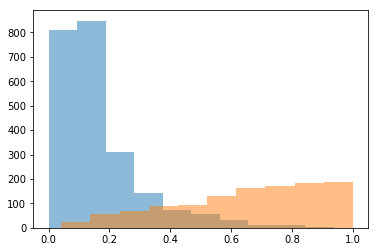

In [21]:
data = sio.loadmat('/Users/dwright/dev/zoo/machine_augmented_classification/data/snhunters/3pi_20x20_skew2_signPreserveNorm.mat')
y_train_true = np.squeeze(data['y'])[order][:split1]
bins = [x for x in np.arange(0,1.04,0.04)]
plt.hist(vote_fractions_train[np.where(y_train_true==0)], alpha=0.5)
plt.hist(vote_fractions_train[np.where(y_train_true==1)], alpha=0.5)
plt.show()

In [22]:
y_train_vote_fractions = vote_fractions_train > 0.5
y_train_dev_vote_fractions = vote_fractions_train_dev > 0.5
y_test_vote_fractions = vote_fractions_test > 0.5

In [23]:
human_vote_fraction_benchmark = f1_score(y_test, y_test_vote_fractions)
unavoidable_bias = 1 - f1_score(y_train, y_train_vote_fractions)

In [24]:
one_percent_fpr(y_train, y_train_vote_fractions, 0.01)

(1.0,
 2,
 array([0.       , 0.0353095, 1.       ]),
 array([0.       , 0.7233677, 1.       ]))

In [25]:
dec = MultitaskDEC(dims=[x_train.shape[-1], 500, 500, 2000, 10], \
                   n_clusters=n_clusters, batch_size=batch_size)
dec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                     ae_weights=ae_weights,
                     x=x_train)
dec.model.load_weights(dec_weights)

In [26]:
cluster_centres = get_cluster_centres(dec)
labels = [str(i) for i in range(n_clusters)]

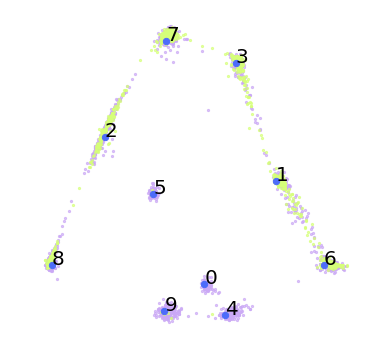

In [27]:
pca_plot(dec.encoder, x_train, cluster_centres, y=y_train, labels=labels, lcolours=[lcolours[0], lcolours[1]])

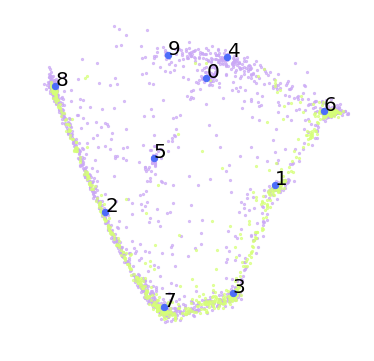

In [28]:
pca_plot(dec.encoder, x_test, cluster_centres, y=y_test, labels=labels, lcolours=[lcolours[0], lcolours[1]])

In [29]:
best_mapping_benchmark, _ = get_best_mapping(y_test, dec.predict_clusters(x_test), n_clusters, calc_f1_score)

In [30]:
y_pred, metrics_dict, best_ite = dec.clustering(x_train, np_utils.to_categorical(y_train_vote_fractions), \
                                               (x_train_dev, np_utils.to_categorical(y_train_dev_vote_fractions)), \
                                               (x_valid, np_utils.to_categorical(y_valid)), \
                                                pretrained_weights=dec_weights, maxiter=maxiter, \
                                                alpha=K.variable(1.0), beta=K.variable(0.0), gamma=K.variable(1.0),  \
                                                loss_weight_decay=False, update_interval=update_interval)

Update interval 1
Save interval 67.5390625
0 105 0 1.0
1 362 0 0.5414364640883977
2 475 0 0.8021052631578948
3 364 0 0.5604395604395604
4 217 0 0.9861751152073732
5 151 0 0.9735099337748344
6 418 0 0.5311004784688995
7 500 0 0.63
8 655 0 0.8274809160305343
9 211 0 0.990521327014218
[0. 1.] [0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
6
Iter 0  :1% fpr 0.9675 , F1= 0.37854 , F1c= 0.29232 h= 0.15223 nmi= 0.07847 ; loss= [0 0 0] ;
 v 1% fpr=, 0.96953 , vF1= 0.37902 , vF1c= 0.2879 vh= 0.15574 vnmi= 0.08364 ; vloss=, [0.89545 0.65711 0.09071 0.23835]
saving model:  [inf, inf, inf]  ->  [0.87588 0.63905 4.20632 0.23683]
1.0 0.0 1.0
saving model to: ./results/dec/DEC_model_0.h5


/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Iter 1  :1% fpr 0.93066 , F1= 0.68677 , F1c= 0.69926 h= 0.31093 nmi= 0.20607 ; loss= [0.72236 0.55405 2.84799 0.16831] ;
 v 1% fpr=, 0.95341 , vF1= 0.62683 , vF1c= 0.65209 vh= 0.2496 vnmi= 0.16934 ; vloss=, [0.68755 0.52616 0.10833 0.16139]
saving model:  [0.87588 0.63905 4.20632 0.23683]  ->  [0.67233 0.5101  1.62483 0.16224]
1.0 0.0 1.0
Iter 2  :1% fpr 0.99567 , F1= 0.64497 , F1c= 0.69899 h= 0.35659 nmi= 0.24254 ; loss= [0.63085 0.47686 0.53044 0.15399] ;
 v 1% fpr=, 0.99462 , vF1= 0.61468 , vF1c= 0.64363 vh= 0.27877 vnmi= 0.18941 ; vloss=, [0.66049 0.50621 0.10255 0.15428]
saving model:  [0.67233 0.5101  1.62483 0.16224]  ->  [0.64815 0.49309 1.95008 0.15507]
1.0 0.0 1.0
Iter 3  :1% fpr 0.89057 , F1= 0.81439 , F1c= 0.83266 h= 0.55219 nmi= 0.40618 ; loss= [0.56016 0.41271 0.73323 0.14745] ;
 v 1% fpr=, 0.88351 , vF1= 0.71058 , vF1c= 0.72693 vh= 0.34625 vnmi= 0.25677 ; vloss=, [0.58929 0.44106 0.09331 0.14823]
saving model:  [0.64815 0.49309 1.95008 0.15507]  ->  [0.5858  0.43654 2.04

In [31]:
dec.model.load_weights('best_train_dev_loss.hf', by_name=True)

In [32]:
avoidable_bias = (1 - metrics_dict['train_f1'][-1]) - unavoidable_bias
bias = unavoidable_bias + avoidable_bias

/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


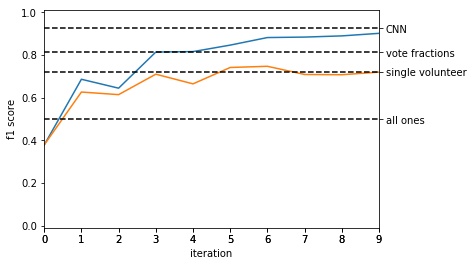

In [33]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(metrics_dict['iteration'], metrics_dict['train_f1'], label='train')
ax1.plot(metrics_dict['iteration'], metrics_dict['valid_f1'], label='validation')
ax1.set_xlim(0,metrics_dict['iteration'][-1])
ax1.set_ylim(-0.01,1.01)
ax1.set_xlabel('iteration')
ax1.set_ylabel('f1 score')

ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.plot(metrics_dict['iteration'], human_f1_benchmark*np.ones(np.array(metrics_dict['iteration']).shape), 'k--')
ax2.plot(metrics_dict['iteration'], human_vote_fraction_benchmark*np.ones(np.array(metrics_dict['iteration']).shape), 'k--')
ax2.plot(metrics_dict['iteration'], all_ones_benchmark*np.ones(np.array(metrics_dict['iteration']).shape), 'k--')
ax2.plot(metrics_dict['iteration'], threepi_cnn_test_f1_benchmark*np.ones(np.array(metrics_dict['iteration']).shape), 'k--')
ax2.set_xlim(0,metrics_dict['iteration'][-1])
ax2.set_ylim(-0.01,1.01)
ax2.set_yticks([all_ones_benchmark, human_f1_benchmark, human_vote_fraction_benchmark, threepi_cnn_test_f1_benchmark])
ax2.set_yticklabels(['all ones', 'single volunteer', 'vote fractions', 'CNN'])
plt.legend(loc='lower center')
plt.show()

/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


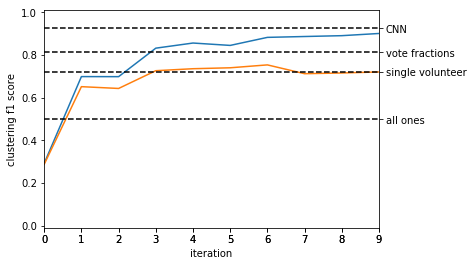

In [34]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(metrics_dict['iteration'], metrics_dict['train_f1c'], label='train')
ax1.plot(metrics_dict['iteration'], metrics_dict['valid_f1c'], label='validation')
ax1.set_xlim(0,metrics_dict['iteration'][-1])
ax1.set_ylim(-0.01,1.01)
ax1.set_xlabel('iteration')
ax1.set_ylabel('clustering f1 score')

ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
#ax2.plot(metrics_dict['iteration'], best_mapping_benchmark*np.ones(np.array(metrics_dict['iteration']).shape), 'k--')
ax2.plot(metrics_dict['iteration'], human_f1_benchmark*np.ones(np.array(metrics_dict['iteration']).shape), 'k--')
ax2.plot(metrics_dict['iteration'], human_vote_fraction_benchmark*np.ones(np.array(metrics_dict['iteration']).shape), 'k--')
ax2.plot(metrics_dict['iteration'], all_ones_benchmark*np.ones(np.array(metrics_dict['iteration']).shape), 'k--')
ax2.plot(metrics_dict['iteration'], threepi_cnn_test_f1_benchmark*np.ones(np.array(metrics_dict['iteration']).shape), 'k--')
ax2.set_xlim(0,metrics_dict['iteration'][-1])
ax2.set_ylim(-0.01,1.01)
#ax2.set_yticks([all_ones_benchmark, best_mapping_benchmark, human_f1_benchmark, human_vote_fraction_benchmark, threepi_cnn_test_f1_benchmark])
ax2.set_yticks([all_ones_benchmark, human_f1_benchmark, human_vote_fraction_benchmark, threepi_cnn_test_f1_benchmark])
#ax2.set_yticklabels(['all ones', 'best mapping', 'single volunteer', 'vote fractions', 'CNN'])
ax2.set_yticklabels(['all ones', 'single volunteer', 'vote fractions', 'CNN'])
plt.legend(loc='lower center')
plt.show()

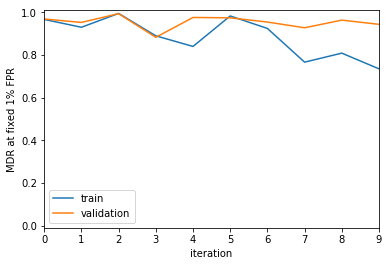

In [35]:
plt.plot(metrics_dict['iteration'], metrics_dict['train_fom'], label='train')
plt.plot(metrics_dict['iteration'], metrics_dict['valid_fom'], label='validation')
plt.xlim(0,metrics_dict['iteration'][-1])
plt.ylim(-0.01,1.01)
plt.xlabel('iteration')
plt.ylabel('MDR at fixed 1% FPR')
plt.legend(loc='lower left')
plt.show()

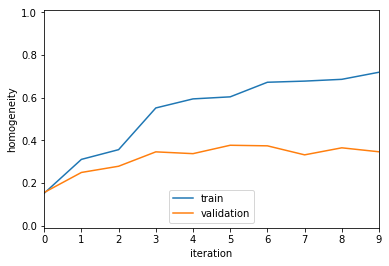

In [36]:
plt.plot(metrics_dict['iteration'], metrics_dict['train_h'], label='train')
plt.plot(metrics_dict['iteration'], metrics_dict['valid_h'], label='validation')
plt.xlim(0,metrics_dict['iteration'][-1])
plt.ylim(-0.01,1.01)
plt.xlabel('iteration')
plt.ylabel('homogeneity')
plt.legend(loc='lower center')
plt.show()

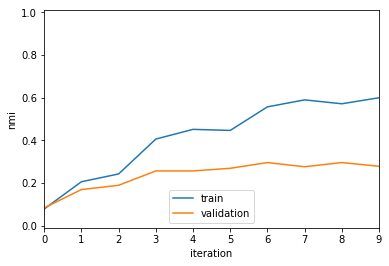

In [37]:
plt.plot(metrics_dict['iteration'], metrics_dict['train_nmi'], label='train')
plt.plot(metrics_dict['iteration'], metrics_dict['valid_nmi'], label='validation')
plt.xlim(0,metrics_dict['iteration'][-1])
plt.ylim(-0.01,1.01)
plt.xlabel('iteration')
plt.ylabel('nmi')
plt.legend(loc='lower center')
plt.show()

In [38]:
cluster_centres = get_cluster_centres(dec)
print(cluster_centres)
labels = [str(i) for i in range(n_clusters)]

[[  5.478715    -0.31389052  -7.072483     1.5692623    7.651622
    0.5489251   -2.721568    -0.7764155    4.368683     0.5601977 ]
 [  3.0915983   -2.8100662   -9.602123     5.8438916    6.0392423
   -2.9453533   -0.2578637    2.8843677   11.450259     3.0173228 ]
 [ -0.53412205  -2.9400754   -1.1749153   -1.5503225   -1.5493522
   -1.0492359    0.7674084    3.2143698    2.8364286    2.3641136 ]
 [  2.8508508   -5.331296    -7.364697     1.373662     1.9356066
   -3.4534514   -0.9354617    5.4032063   11.551789     4.447453  ]
 [ -0.34886065  -0.02980793  -6.83578      7.9561286    5.7129536
   -1.7879316    1.8518809    0.6890703    6.7559023    1.6266993 ]
 [  5.003615    -1.0236264   -1.8810477   -2.0475278    3.7430706
    0.02547795  -5.1954446   -0.25339264   6.0948095    0.18699913]
 [  3.5908673   -1.9917369  -12.461936     9.127502     9.399479
   -3.092844    -0.21977603   2.22618     12.963923     3.0443194 ]
 [  1.06358     -5.436052    -4.3773265   -1.5396879   -1.128345

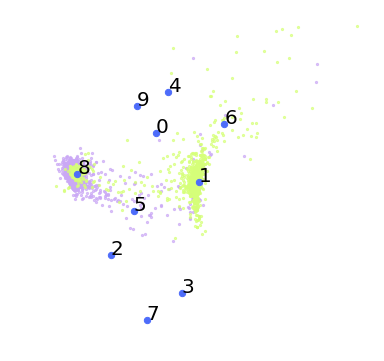

In [39]:
pca_plot(dec.encoder, x_train, cluster_centres, y=y_train, labels=labels, lcolours=[lcolours[0], lcolours[1]])

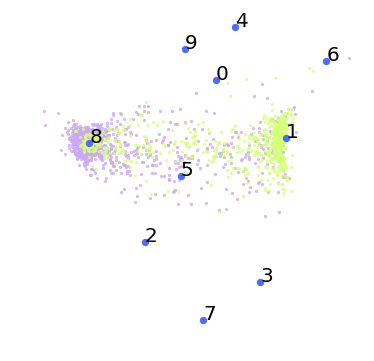

In [40]:
pca_plot(dec.encoder, x_test, cluster_centres, y=y_test, labels=labels, lcolours=[lcolours[0], lcolours[1]])

In [41]:
class ReDEC(DEC):
    def clustering(self, train_data, valid_data=None,
                   tol=1e-3,
                   update_interval=140,
                   maxiter=2e4,
                   pretrained_weights=None,
                   metrics_dict=None,
                   last_ite=0,
                   save_dir='./results/dec'):
        x = np.concatenate((x_train, x_test))
        print('Update interval', update_interval)
        save_interval = x.shape[0] / self.batch_size * 5  # 5 epochs
        print('Save interval', save_interval)

        frame_index = 1

        import csv, os
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        
        if metrics_dict is None:
          metrics_dict = {'iteration':[],
                          'train_f1c':[],
                          'train_h':[],
                          'train_nmi':[],
                          'valid_f1c':[],
                          'valid_h':[],
                          'valid_nmi':[]
                          }
        loss = 0
        index = 0
        for ite in range(int(maxiter)):
            if self.video_path:
                self.model.save_weights(self.video_path+'/%s_%06d_weights.h5'%('clustering', frame_index))
                frame_index += 1

            if ite % update_interval == 0:
                q = self.model.predict(x, verbose=0)
                p = self.target_distribution(q)  # update the auxiliary target distribution p

                # evaluate the clustering performance
                y_pred = q.argmax(1)
                if ite > 0:
                  delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
                y_pred_last = y_pred
                if valid_data is not None:
                  loss = np.round(loss, 5)
                  train_q = self.model.predict(train_data[0], verbose=0)
                  train_p = self.target_distribution(train_q)
                  c_map, _, _ = \
                    get_cluster_to_label_mapping_safe(train_data[1], train_q.argmax(1), n_classes, n_clusters, toprint=False)
                  train_cluster_pred = self.model.predict(train_data[0], verbose=0).argmax(1)
                  f1c = np.round(calc_f1_score(train_data[1], train_cluster_pred, c_map), 5)
                  h = np.round(homogeneity_score(train_data[1], train_cluster_pred), 5)
                  nmi = np.round(normalized_mutual_info_score(train_data[1], train_cluster_pred), 5)
                    
                  valid_q = self.model.predict(valid_data[0], verbose=0)
                  valid_p = self.target_distribution(valid_q)
                  val_loss = np.round(self.model.test_on_batch(valid_data[0], valid_p), 5)
                  valid_cluster_pred = valid_q.argmax(1)
                  f1c_valid = np.round(calc_f1_score(valid_data[1], valid_cluster_pred, c_map), 5)
                  h_valid = np.round(homogeneity_score(valid_data[1], valid_cluster_pred), 5)
                  nmi_valid = np.round(normalized_mutual_info_score(valid_data[1], valid_cluster_pred), 5)

                  print('Iter', ite,', F1c=', f1c, 'h=', h, 'nmi=', nmi, '; loss=', loss, ';', \
                        'vF1c=', f1c_valid,'vh=', h_valid, 'vnmi=', nmi_valid, '; vloss=,', val_loss)
                  metrics_dict['iteration'].append(last_ite+ite)
                  metrics_dict['train_f1c'].append(f1c)
                  metrics_dict['train_h'].append(h)
                  metrics_dict['train_nmi'].append(nmi)
                  metrics_dict['valid_f1c'].append(f1c_valid)
                  metrics_dict['valid_h'].append(h_valid)
                  metrics_dict['valid_nmi'].append(nmi_valid)
                # check stop criterion
                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    break

            # train on batch
            if (index + 1) * self.batch_size > x.shape[0]:
                loss = self.model.train_on_batch(x=x[index * self.batch_size::],
                                                 y=p[index * self.batch_size::])
                index = 0
            else:
                loss = self.model.train_on_batch(x=x[index * self.batch_size:(index + 1) * self.batch_size],
                                                 y=p[index * self.batch_size:(index + 1) * self.batch_size])
                index += 1

            # save intermediate model
            if ite % save_interval == 0:
                # save IDEC model checkpoints
                print('saving model to:', save_dir + '/DEC_model_' + str(ite) + '.h5')
                self.model.save_weights(save_dir + '/DEC_model_' + str(ite) + '.h5')

            ite += 1

        # save the trained model
        print('saving model to:', save_dir + '/DEC_model_final.h5')
        self.model.save_weights(save_dir + '/DEC_model_final.h5')

        return y_pred, metrics_dict

In [42]:
redec = ReDEC(dims=[x_test.shape[-1], 500, 500, 2000, 10], \
                   n_clusters=n_clusters, batch_size=batch_size)
redec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                     ae_weights=ae_weights,
                     x=x_train)
redec.model.load_weights(dec_weights)

In [43]:
dec.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 10)           1473010     input_1[0][0]                    
__________________________________________________________________________________________________
clustering (ClusteringLayer)    (None, 10)           100         model_2[1][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            22          clustering[0][0]                 
__________________________________________________________________________________________________
model_1 (M

In [44]:
redec.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 400)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               200500    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 10)                100       
Total params: 1,473,110
Trainable params: 1,473,110
Non-trainable params: 0
_________________________________________________________________


In [45]:
dec.model.layers[1]

In [46]:
for i in range(1,len(dec.model.layers[1].layers)):
    redec.model.layers[i].set_weights(dec.model.layers[1].layers[i].get_weights())
redec.model.layers[-1].set_weights(dec.model.layers[2].get_weights())

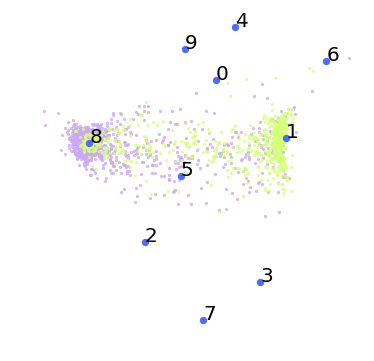

In [47]:
pca_plot(redec.encoder, x_test, cluster_centres, y=y_test, labels=labels, lcolours=[lcolours[0], lcolours[1]])

In [48]:
y_pred, metrics_dict = redec.clustering((np.concatenate((x_train, x_train_dev)), np.concatenate((y_train, y_train_dev))), \
                                        (x_valid, y_valid), pretrained_weights=None, \
                                        maxiter=2e4, update_interval=140, metrics_dict=metrics_dict, last_ite=maxiter)

Update interval 140
Save interval 112.51953125


/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Iter 0 , F1c= 0.80226 h= 0.4302 nmi= 0.35803 ; loss= 0 ; vF1c= 0.75419 vh= 0.37449 vnmi= 0.29594 ; vloss=, 0.07016
saving model to: ./results/dec/DEC_model_0.h5
Iter 140 , F1c= 0.80131 h= 0.42954 nmi= 0.35127 ; loss= 0.03472 ; vF1c= 0.74953 vh= 0.37391 vnmi= 0.29275 ; vloss=, 0.0713
Iter 280 , F1c= 0.80215 h= 0.43346 nmi= 0.34776 ; loss= 0.04831 ; vF1c= 0.74977 vh= 0.37919 vnmi= 0.29192 ; vloss=, 0.07408
Iter 420 , F1c= 0.79916 h= 0.43316 nmi= 0.34186 ; loss= 0.05033 ; vF1c= 0.74882 vh= 0.38659 vnmi= 0.29056 ; vloss=, 0.0765
Iter 560 , F1c= 0.8013 h= 0.43398 nmi= 0.33681 ; loss= 0.05187 ; vF1c= 0.75229 vh= 0.37942 vnmi= 0.28369 ; vloss=, 0.0784
Iter 700 , F1c= 0.80048 h= 0.43201 nmi= 0.33213 ; loss= 0.04974 ; vF1c= 0.74233 vh= 0.38257 vnmi= 0.28294 ; vloss=, 0.08106
Iter 840 , F1c= 0.79928 h= 0.43325 nmi= 0.33178 ; loss= 0.0607 ; vF1c= 0.73485 vh= 0.38473 vnmi= 0.28249 ; vloss=, 0.08232
Iter 980 , F1c= 0.80023 h= 0.42936 nmi= 0.32798 ; loss= 0.07339 ; vF1c= 0.7379 vh= 0.36712 vnmi= 0.2

[[ 5.6215363e+00 -2.4805893e-01 -7.1244173e+00  1.5157604e+00
   7.8110948e+00  6.3405377e-01 -2.8226464e+00 -8.8551611e-01
   4.2797379e+00  4.9993542e-01]
 [ 3.3909278e+00 -3.4586613e+00 -9.9819517e+00  5.5934806e+00
   5.8148370e+00 -3.3323798e+00 -5.1142544e-01  3.5358343e+00
   1.2432611e+01  3.4831705e+00]
 [-3.4710833e-01 -3.1702306e+00 -1.2373437e+00 -1.7340738e+00
  -1.7484788e+00 -1.2225808e+00  6.1147642e-01  3.4451377e+00
   3.1491644e+00  2.5290704e+00]
 [ 2.7032459e+00 -5.3543277e+00 -7.5932660e+00  1.3610473e+00
   1.9629904e+00 -3.3676143e+00 -6.1024851e-01  5.4947009e+00
   1.1442783e+01  4.5028048e+00]
 [-3.0478522e-01  1.3196382e-01 -6.8870797e+00  8.1666842e+00
   5.9117169e+00 -1.8039291e+00  1.8959571e+00  4.9021998e-01
   6.6626692e+00  1.5029669e+00]
 [ 5.1225929e+00 -9.8353481e-01 -1.8221622e+00 -2.1466401e+00
   3.8094089e+00  7.1983919e-02 -5.3506684e+00 -3.3459792e-01
   6.1132026e+00  1.2858564e-01]
 [ 3.5439346e+00 -1.7581868e+00 -1.2960383e+01  9.9439278e

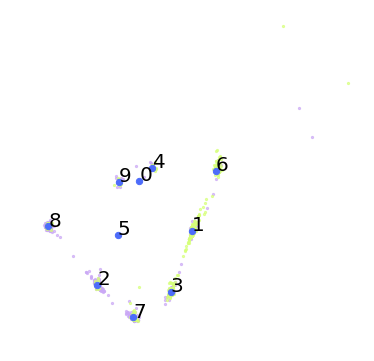

In [49]:
cluster_centres = get_cluster_centres(redec)
print(cluster_centres)
labels = [str(i) for i in range(n_clusters)]
pca_plot(redec.encoder, x_train, cluster_centres, y=y_train, labels=labels, lcolours=[lcolours[0], lcolours[1]])

/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


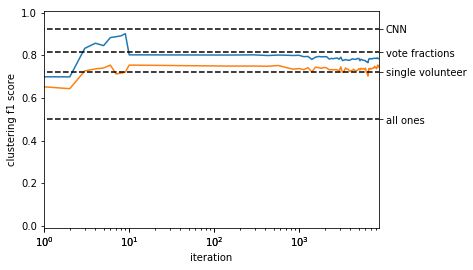

In [71]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(metrics_dict['iteration'], metrics_dict['train_f1c'], label='train')
ax1.plot(metrics_dict['iteration'], metrics_dict['valid_f1c'], label='validation')
ax1.set_xlim(0,metrics_dict['iteration'][-1])
ax1.set_ylim(-0.01,1.01)
ax1.set_xlabel('iteration')
ax1.set_ylabel('clustering f1 score')
ax1.set_xscale('log')

ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
#ax2.plot(metrics_dict['iteration'], best_mapping_benchmark*np.ones(np.array(metrics_dict['iteration']).shape), 'k--')
ax2.plot(metrics_dict['iteration'], human_f1_benchmark*np.ones(np.array(metrics_dict['iteration']).shape), 'k--')
ax2.plot(metrics_dict['iteration'], human_vote_fraction_benchmark*np.ones(np.array(metrics_dict['iteration']).shape), 'k--')
ax2.plot(metrics_dict['iteration'], all_ones_benchmark*np.ones(np.array(metrics_dict['iteration']).shape), 'k--')
ax2.plot(metrics_dict['iteration'], threepi_cnn_test_f1_benchmark*np.ones(np.array(metrics_dict['iteration']).shape), 'k--')
ax2.set_xlim(0,metrics_dict['iteration'][-1])
ax2.set_ylim(-0.01,1.01)
#ax2.set_yticks([all_ones_benchmark, best_mapping_benchmark, human_f1_benchmark, human_vote_fraction_benchmark, threepi_cnn_test_f1_benchmark])
ax2.set_yticks([all_ones_benchmark, human_f1_benchmark, human_vote_fraction_benchmark, threepi_cnn_test_f1_benchmark])
#ax2.set_yticklabels(['all ones', 'best mapping', 'single volunteer', 'vote fractions', 'CNN'])
ax2.set_yticklabels(['all ones', 'single volunteer', 'vote fractions', 'CNN'])
ax2.set_xscale('log')
plt.legend(loc='lower center')
plt.show()

In [51]:
train_q = redec.model.predict(np.concatenate((x_train, x_train_dev)), verbose=0)
#train_p = self.target_distribution(train_q)
c_map, _, _ = \
  get_cluster_to_label_mapping_safe(np.concatenate((y_train, y_train_dev)), train_q.argmax(1), n_classes, n_clusters, toprint=False)
  
test_q = redec.model.predict(x_test, verbose=0)
test_p = redec.target_distribution(test_q)
test_cluster_pred = test_q.argmax(1)
f1c_test = np.round(calc_f1_score(y_test, test_cluster_pred, c_map), 5)
h_test = np.round(homogeneity_score(y_test, test_cluster_pred), 5)
nmi_test = np.round(normalized_mutual_info_score(y_test, test_cluster_pred), 5)
print(f1c_test, h_test, nmi_test)

/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.70502 0.33016 0.20437


In [53]:
import pickle
metrics_dict['tesf_f1c'] = f1c_test
metrics_dict['test_h'] = h_test
metrics_dict['test_nmi'] = nmi_test
pickle.dump(metrics_dict, open('metrics_dict_paper.pkl', 'wb'))

In [54]:
def getDimensions(n):
  dim = int(np.ceil(np.sqrt(n)))
  return (dim, dim)

In [55]:
def plotCluster(cluster_labels, cluster, X, image_dim, channels=1, limit=200, cmap='gray_r', rotation=0, order='C'):
  indices = np.where(cluster_labels == cluster)[0] # get the examples assigned to cluster 0
  perm = np.random.permutation(len(indices))
  indices = indices[perm]
  n = np.where(cluster_labels == cluster)[0].shape[0]
  print(n)
  if n > limit:
    indices = indices[:limit]
    n = limit
    
  dims = getDimensions(n)
    
  fig = plt.figure(figsize=(10,10))
  for i in range(n):
    ax = fig.add_subplot(dims[0],dims[1],i+1)
    if channels > 1:
      ax.imshow(np.rot90(np.reshape(X[indices[i]], (image_dim,image_dim, channels), order=order), rotation), cmap=cmap)
    elif channels == 1:
      ax.imshow(np.rot90(np.reshape(X[indices[i]], (image_dim,image_dim), order=order), rotation), cmap=cmap) 
    plt.axis('off')
  plt.show()

221


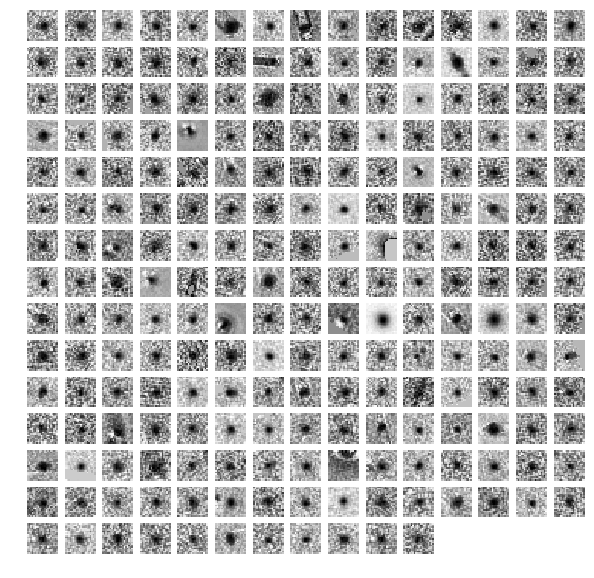

In [64]:
plotCluster(y_pred, 6, np.concatenate((x_train, x_train_dev, x_valid)), 20, limit=221)

137


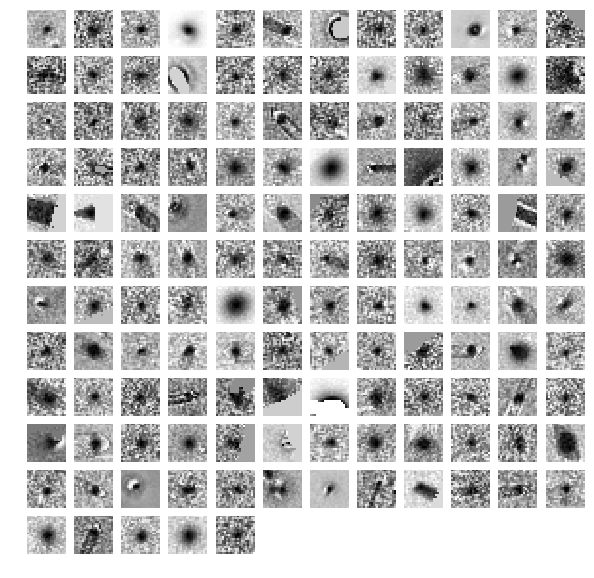

In [65]:
plotCluster(y_pred, 4, np.concatenate((x_train, x_train_dev, x_valid)), 20, limit=137)

2637


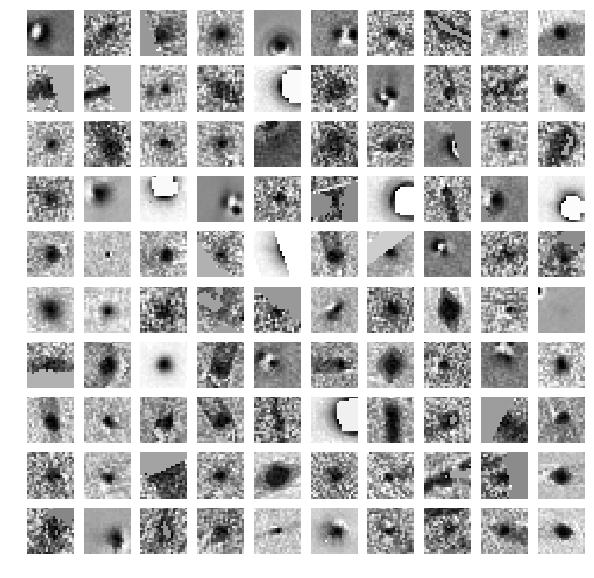

In [61]:
plotCluster(y_pred, 8, np.concatenate((x_train, x_train_dev, x_valid)), 20, limit=100)

671


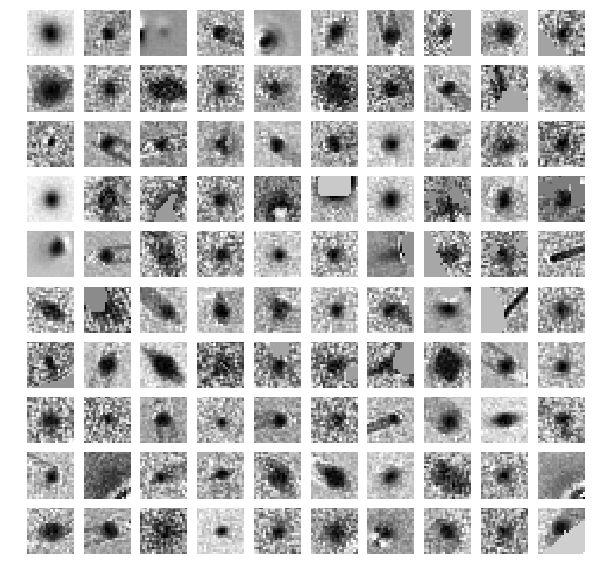

In [62]:
plotCluster(y_pred, 2, np.concatenate((x_train, x_train_dev, x_valid)), 20, limit=100)

1151


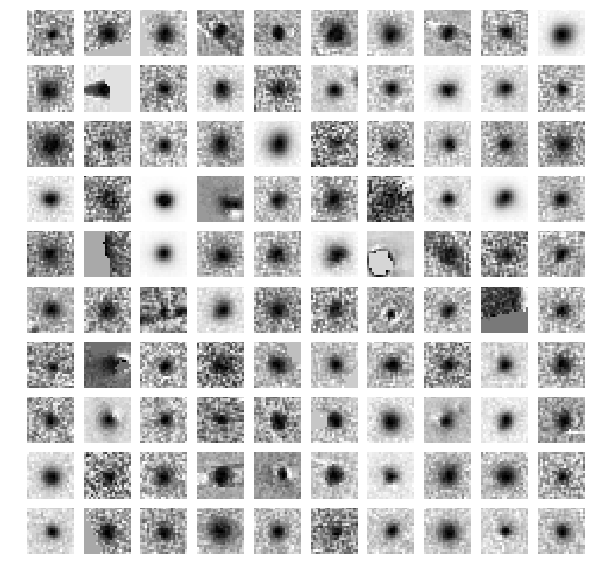

In [63]:
plotCluster(y_pred, 1, np.concatenate((x_train, x_train_dev, x_valid)), 20, limit=100)

67


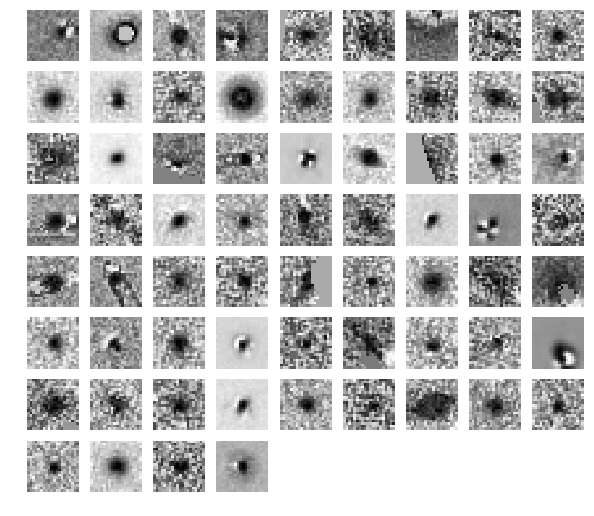

In [66]:
plotCluster(y_pred, 9, np.concatenate((x_train, x_train_dev, x_valid)), 20, limit=100)

519


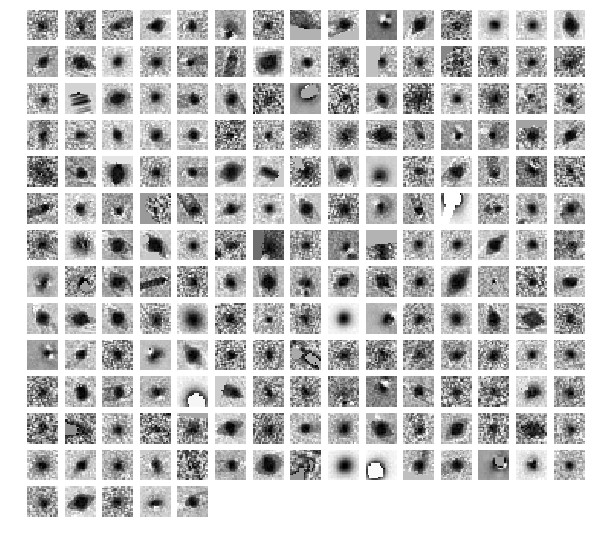

In [69]:
plotCluster(y_pred, 7, np.concatenate((x_train, x_train_dev, x_valid)), 20, limit=200)

358


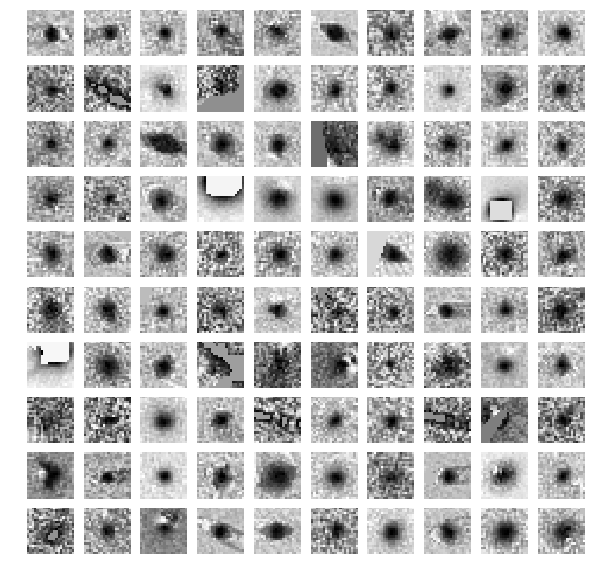

In [70]:
plotCluster(y_pred, 3, np.concatenate((x_train, x_train_dev, x_valid)), 20, limit=100)